# Part 2: 
#### Measuring an impact of influencers reviews on businesses: studying how (positive 5 stars) reviews of influencers effect on an average rating and frequency of other user`s reviews 

##### Importing libraries...

In [869]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import pymongo
import pprint
from pymongo import MongoClient
import datetime as dt
%matplotlib inline

##### Creating a data base connection...

In [870]:
client = MongoClient('mongodb://localhost:27017')
db = client.yelp
con_check = str(db)
if con_check.find('yelp') != int(-1):
    print('...Connected')
else:
    print('...Connection Failed')

...Connected


##### Reading influencers list file...


In [871]:
top_df = pd.read_json('intermediate_datasets\influencers.json')
top_df = top_df.sort_values(['count_friends'], ascending=False) # Sorting influencers by the number of friends
top_df = top_df.sort_values(['fans'], ascending=False) # Sorting influencers by the number of fans
top_df.head()
# not sorting by the number of elite years as in this case the sorting gives contoversial results

,_id,count_elite,count_friends,fans
2.0,spJUPXI7QaIctU0FO5c42w,7,2789,1363
25.0,7uxXuCcpw9-mUS3OJVw8aQ,11,1751,1339
17.0,8E0DGec8LNn6oDmPHmj-mg,8,1963,1323
69.0,UTGqubcmDv1cNe5-k8-OeA,8,1023,1184
12.0,w6Vv-kldGpmvSGqXvTbAdQ,6,2086,1180


##### Choosing an influencer from the list...

In [872]:
influencer = top_df._id[(top_df.index[710])] # Picking a particular influencer from the list index[]
influencer_reviews = list(db.review.find({"user_id":influencer})) # fetching all reviews done by this influencer from the data base
influencer

'2OW_K0waHOGZy536SFC-EQ'

##### Choosing a particular business...

In [873]:
infl_reviews_df = pd.DataFrame(influencer_reviews) # Creating a data frame for influenccer reviews
#----------------------------------------------------------------------------------------------------------------------------
infl_reviews_df = infl_reviews_df.sort_values('date', ascending=True)    
# sorting influencers reviews to have the earliest reviews of the most positive reviews on the top of the list
# ensuring the first positive influencer`s review of businesses
infl_reviews_df = infl_reviews_df.sort_values('stars', ascending=False)
#----------------------------------------------------------------------------------------------------------------------------
infl_reviews_df.head(2)

,_id,business_id,date,review_id,stars,text,type,user_id,votes
0,57712c007b99e72215591dd5,eLPld7Q17XxlclFGzZQX5g,2010-01-13,ZngN_6lFBz_0MDaTn3eiRA,5,Awesome place!\n\nWe got to the restaurant aro...,review,2OW_K0waHOGZy536SFC-EQ,"{'useful': 3, 'cool': 2, 'funny': 1}"
3,57712c407b99e722155f7046,h3cVHInSrkLsfa1BJ80RJQ,2011-03-01,gZg5bUB9ChNfxg-k9kDI-w,5,WOW! This was my first Vegas show as it was mo...,review,2OW_K0waHOGZy536SFC-EQ,"{'useful': 1, 'cool': 1, 'funny': 1}"


In [874]:
# Picking business_id of the first review in influencer`s reviews data frame
infl_business_id = infl_reviews_df.business_id[(infl_reviews_df.index[0])]
# Fetching all reviews of the chosen business from the data base
infl_business_reviews = list(db.review.find({"business_id":infl_business_id}))


In [875]:
infl_business_reviews_df = pd.DataFrame(infl_business_reviews) # Creating data frame of all reviews of a chosen business
infl_business_reviews_df.head(2)


,_id,business_id,date,review_id,stars,text,type,user_id,votes
0,57712c007b99e72215591dad,eLPld7Q17XxlclFGzZQX5g,2006-07-03,2emyO6ti6Mum9HaAWZXlyw,4,Thinking about fresh uni reminded me about the...,review,bu28jqWB_wi_c1Bo49CIAA,"{'useful': 0, 'cool': 0, 'funny': 0}"
1,57712c007b99e72215591db0,eLPld7Q17XxlclFGzZQX5g,2006-09-30,Vl4PwxI2NHxtJnIqr1FCDQ,3,Good deal on the all-you-can-eat where it's ev...,review,1ADzO1AOjVDuByLzaX3pgg,"{'useful': 0, 'cool': 0, 'funny': 0}"


##### Plotting reviews stars vs dates...

In [876]:
dates = list(infl_business_reviews_df.date) # Creating a list of dates of all reviews a business has
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates] # Changing dates type to datetime type
y = list(infl_business_reviews_df.stars) # Creating a list of reviews rating


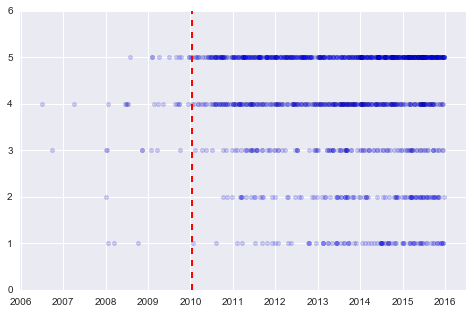

In [877]:
# Finding the date of influencer`s first top rated review for
infl_review_date = infl_business_reviews_df[(infl_business_reviews_df.user_id == influencer)].date 

# Changing influencer`s review date to string type
datex = list(infl_review_date)
infl_review_date = datex[0]


fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)
ax.axvline(pd.to_datetime(infl_review_date) , color='r', linestyle='--', lw=2) # Red treshold line = date of influencer`s review


In [878]:
infl_review_date

'2010-01-13'

In [879]:
# Creating a data frame with reviews before influencer`s review 
before_review_df = infl_business_reviews_df[infl_business_reviews_df.date <= infl_review_date]


In [880]:
#-------------------------------------------------------------------------------------------------------------------------------
# Calculating average rating before the influencer`s review
stars_sum = 0
for stars in before_review_df.stars:
    stars_sum = stars + stars_sum
reviews_count = before_review_df.stars.count()
avg_stars = stars_sum/reviews_count
#-------------------------------------------------------------------------------------------------------------------------------

before_dates_from_df = list(before_review_df.date) # Getting all dates before an influencer`s review date
before_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in before_dates_from_df] # Converting dates type to datetime type
# Calculating the differnece in days between the date of the first review and the date when an influencer has made a review
days_before_1st_review = abs((before_dates[-1] - before_dates[0]).days) # Number of days from first review up to the treshold
weeks_before_1st_review = days_before_1st_review/7 
months_before_1s_review = weeks_before_1st_review/4

print('Average stars of the business before:',avg_stars)
print('Daily reviews frequiency before:', reviews_count/days_before_1st_review)
print('Weekly reviews frequiency before:', reviews_count/weeks_before_1st_review)
print('Monthly reviews frequiency before:', reviews_count/months_before_1s_review)
print('Number of reviews before:', reviews_count)


Average stars of the business before: 3.82051282051
Daily reviews frequiency before: 0.0302325581395
Weekly reviews frequiency before: 0.211627906977
Monthly reviews frequiency before: 0.846511627907
Number of reviews before: 39


In [881]:
# Creating a data frame with reviews after an influencer`s review 
after_review_df = infl_business_reviews_df[infl_business_reviews_df.date > infl_review_date]

In [882]:
#-------------------------------------------------------------------------------------------------------------------------------
# Calculating average rating after an influencer`s review
stars_sum = 0
for stars in after_review_df.stars:
    stars_sum = stars + stars_sum
reviews_count = after_review_df.stars.count()
avg_stars = stars_sum/reviews_count
#-------------------------------------------------------------------------------------------------------------------------------
after_dates_from_df = list(after_review_df.date) # Getting all dates after an influencer`s review date
after_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in after_dates_from_df] # Converting dates type to datetime type
# Calculating the differnece in days between the date of the the last review and the date when an influencer has made a review
days_after_1st_review = abs((after_dates[-1] - after_dates[0]).days) # Number of days from the treshold up to the last review
weeks_after_1st_review = days_after_1st_review/7
months_after_1s_review = weeks_after_1st_review/4

print('Average stars of the business after:',avg_stars)
print('Daily reviews frequiency before:', reviews_count/days_after_1st_review)
print('Weekly reviews frequiency before:', reviews_count/weeks_after_1st_review)
print('Monthly reviews frequiency before:', reviews_count/months_after_1s_review)
print('Number of reviews after:', reviews_count)



Average stars of the business after: 3.97884940778
Daily reviews frequiency before: 0.544951590595
Weekly reviews frequiency before: 3.81466113416
Monthly reviews frequiency before: 15.2586445367
Number of reviews after: 1182
